<a href="https://colab.research.google.com/github/seer9/atlas-machine_learning/blob/main/btc_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependencies

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

Preprocess BTC data

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
def preprocess_data(
        file=('/content/drive/MyDrive/time_series/coinbase.csv'),
        window_size=24):

    ds = pd.read_csv(file)
    print(f"Successfully loaded dataset from {file}")


    # print column
    print("Columns in dataset:", ds.columns)
    if 'Close' in ds.columns:
        ds = ds[['Close']]
    elif 'close' in ds.columns:
        ds = ds[['close']]
    else:
        raise ValueError("Close or close column not found in dataset")

    # drop NaN values
    ds = ds.dropna()

    # normalize the data
    scaler = MinMaxScaler()
    ds_scaled = scaler.fit_transform(ds)

    # create windows
    X, y = [], []
    for i in range(len(ds_scaled) - window_size):
        X.append(ds_scaled[i:i + window_size])
        y.append(ds_scaled[i + window_size])

    # save
    np.save('X.npy', np.array(X))
    np.save('y.npy', np.array(y))
    np.save('scaler.npy', scaler)

if __name__ == '__main__':
    preprocess_data()

Successfully loaded dataset from /content/drive/MyDrive/time_series/coinbase.csv
Columns in dataset: Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')


load data and create pipeline

In [58]:
# load preprocessed data
X = np.load('X.npy')
Y = np.load('y.npy')

# create the data pipeline
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.batch(64).shuffle(1000).prefetch(tf.data.AUTOTUNE)

build, compile and fit

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# define the model
num_features = X.shape[2] # the number of features per time step

# building the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X.shape[1:]),
    tf.keras.layers.Dense(1)
])

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# model summary to check the output shape
model.summary()

# train the model
model.fit(dataset, epochs=10)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 662s 21ms/step - loss: 1.0237e-06
Epoch 2/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 631s 20ms/step - loss: 4.6358e-07
Epoch 3/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 630s 20ms/step - loss: 3.3848e-07
Epoch 4/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 631s 20ms/step - loss: 4.1617e-07
Epoch 5/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 666s 20ms/step - loss: 3.2338e-07
Epoch 6/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 609s 20ms/step - loss: 2.5231e-07
Epoch 7/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 614s 19ms/step - loss: 2.2812e-07
Epoch 8/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 605s 19ms/step - loss: 2.3445e-07
Epoch 9/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 583s 19ms/step - loss: 1.8331e-07
Epoch 10/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 626s 19ms/step - loss: 1.6275e-07


save model for forecasting

In [61]:
# save the model
model.save('btc_forecasting.h5')

Validating by split up the data and retraining the model with validation tracking.

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)

retraining model

In [64]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(tf.data.AUTOTUNE)

model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 468s 19ms/step - loss: 1.1773e-07 - val_loss: 1.4672e-04
Epoch 2/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 470s 19ms/step - loss: 3.9717e-06 - val_loss: 2.3456e-04
Epoch 3/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 466s 19ms/step - loss: 7.1457e-06 - val_loss: 2.3456e-04
Epoch 4/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 495s 20ms/step - loss: 7.5237e-06 - val_loss: 1.9920e-04
Epoch 5/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 495s 20ms/step - loss: 6.5244e-06 - val_loss: 1.6314e-04
Epoch 6/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 464s 18ms/step - loss: 5.4120e-06 - val_loss: 1.3905e-04
Epoch 7/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 486s 20ms/step - loss: 4.6332e-06 - val_loss: 1.2223e-04
Epoch 8/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 454s 18ms/step - loss: 4.0630e-06 - val_loss: 1.0561e-04
Epoch 9/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 449s 18ms/step - loss: 3.4368e-06 - val_loss: 9.9951e-05
Epoch 10/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 450s 18ms/step - loss: 3.2563e-06 - val_loss: 

12442/12442 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step
Shape of y_pred_inv: (398134, 1)
Shape of y_val_inv: (398134, 1)


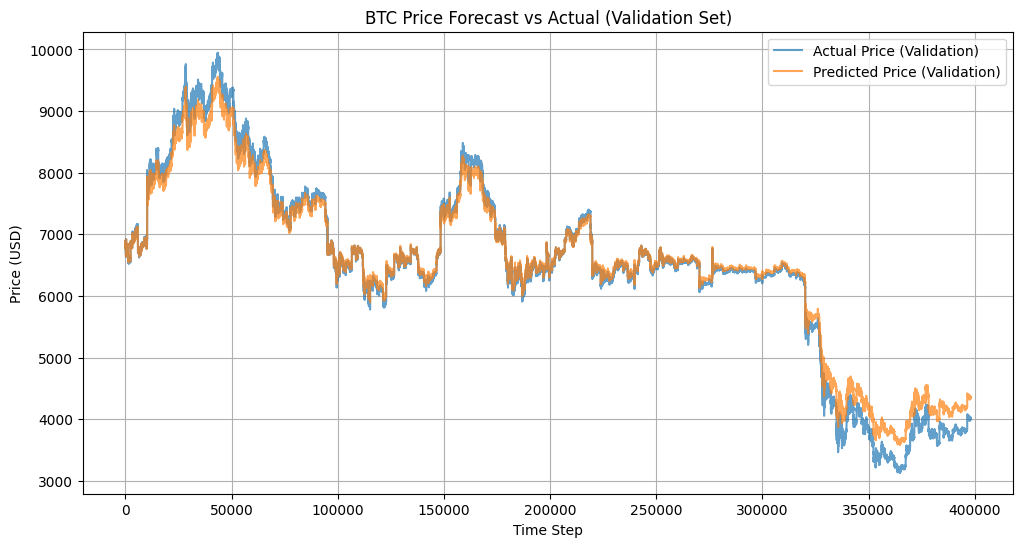

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions using the trained model on the validation set
y_pred = model.predict(X_val)

# Load the scaler
scaler = np.load('scaler.npy', allow_pickle=True).item()


# Inverse transform predictions and actual validation values
y_pred_inv = scaler.inverse_transform(y_pred)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Print shapes for debugging
print("Shape of y_pred_inv:", y_pred_inv.shape)
print("Shape of y_val_inv:", y_val_inv.shape)

# Plot actual validation vs predicted validation prices on the original scale
plt.figure(figsize=(12, 6))
# plt.plot() with a 2D array of shape (n_samples, 1) plots a single line
plt.plot(y_val_inv, label='Actual Price (Validation)', alpha=0.7)
plt.plot(y_pred_inv, label='Predicted Price (Validation)', alpha=0.7)
plt.title('BTC Price Forecast vs Actual (Validation Set)')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()